# Analyze Ranking of Videos

# Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Show all columns
pd.set_option("display.max_columns", None)

# Đọc dữ liệu từ file csv

In [2]:
# Define data types of some columns
dtypes = {
    "author.uniqueId": np.object_,
    "video.id": np.object_,
}

# Load data from CSV file
video_df = pd.read_csv("./data/interim/videos_with_weekly_rank.csv",
                       dtype=dtypes, parse_dates=["createTime"])

In [3]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70996 entries, 0 to 70995
Data columns (total 70 columns):
 #   Column                           Non-Null Count  Dtype                    
---  ------                           --------------  -----                    
 0   Unnamed: 0                       70996 non-null  int64                    
 1   CategoryType                     70996 non-null  float64                  
 2   author.downloadSetting           70996 non-null  float64                  
 3   author.duetSetting               70996 non-null  float64                  
 4   author.id                        70996 non-null  int64                    
 5   author.nickname                  70996 non-null  object                   
 6   author.openFavorite              70996 non-null  bool                     
 7   author.secUid                    70996 non-null  object                   
 8   author.signature                 70140 non-null  object                   
 9   author

## Phân tích duration các Video

In [4]:
video_df['video.duration'].describe(), video_df['music.duration'].describe()

(count    70996.000000
 mean        76.913432
 std         69.930126
 min          0.000000
 25%         38.000000
 50%         64.000000
 75%         93.000000
 max       1480.000000
 Name: video.duration, dtype: float64,
 count    70877.000000
 mean       103.384412
 std         82.933272
 min          1.000000
 25%         57.000000
 50%         81.000000
 75%        130.000000
 max       1481.000000
 Name: music.duration, dtype: float64)

<Axes: ylabel='Frequency'>

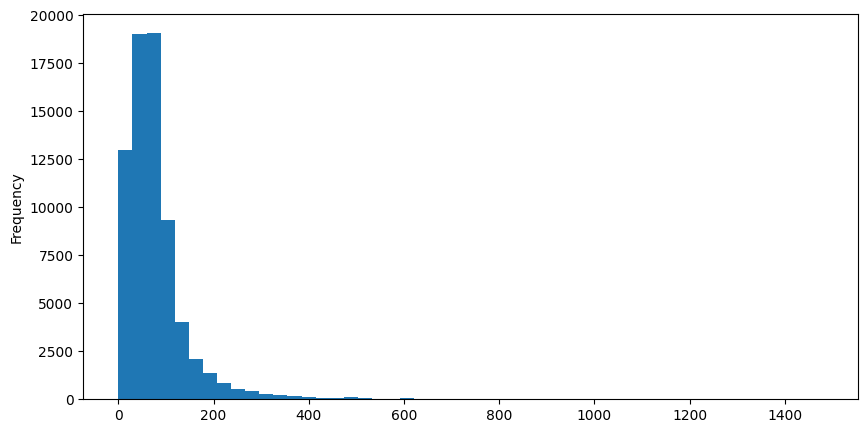

In [5]:
video_df["video.duration"].plot(kind="hist", bins=50, figsize=(10, 5))

<Axes: >

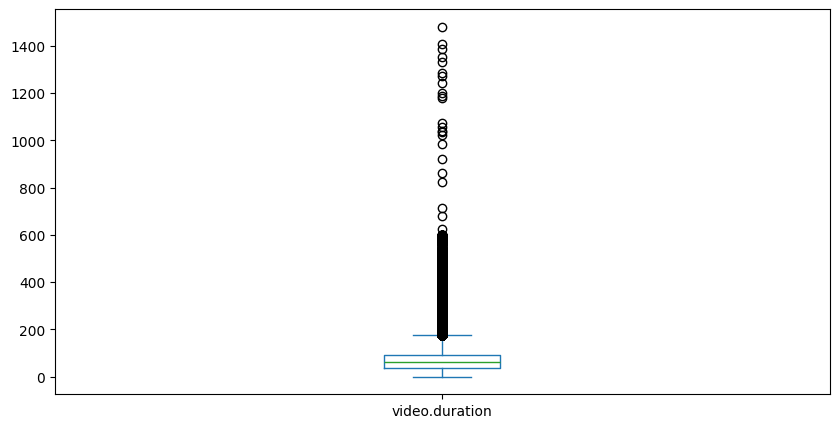

In [6]:
video_df["video.duration"].plot(kind="box", figsize=(10, 5))

Q1: 38.00
Q3: 93.00
IQR: 55.00
Lower bound: -44.50
Upper bound: 175.50
Number of outliers: 4597 (6.48% of total videos)


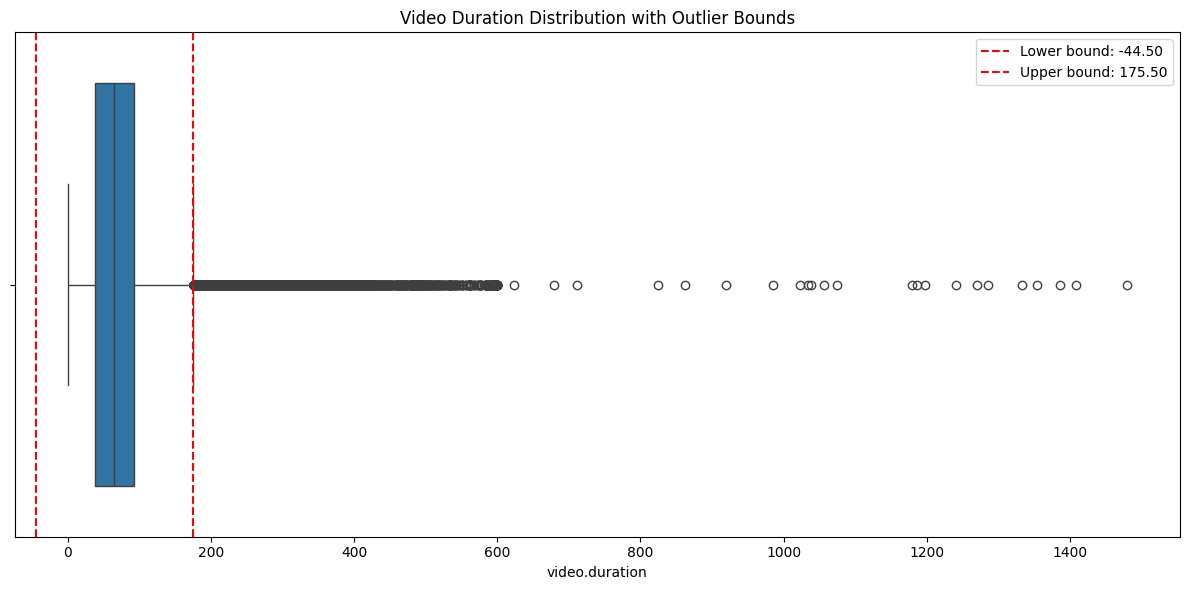

In [7]:
# Calculate quartiles and IQR for video duration
q1 = video_df['video.duration'].quantile(0.25)
q3 = video_df['video.duration'].quantile(0.75)
iqr = q3 - q1

# Calculate bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Count outliers
outliers = video_df[(video_df['video.duration'] < lower_bound)
                    | (video_df['video.duration'] > upper_bound)]
outlier_count = len(outliers)

# Display results
print(f"Q1: {q1:.2f}")
print(f"Q3: {q3:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(
    f"Number of outliers: {outlier_count} ({outlier_count/len(video_df)*100:.2f}% of total videos)")

# Optional: visualize with a boxplot highlighting the bounds
plt.figure(figsize=(12, 6))
sns.boxplot(x=video_df['video.duration'])
plt.axvline(x=lower_bound, color='r', linestyle='--',
            label=f'Lower bound: {lower_bound:.2f}')
plt.axvline(x=upper_bound, color='r', linestyle='--',
            label=f'Upper bound: {upper_bound:.2f}')
plt.title('Video Duration Distribution with Outlier Bounds')
plt.legend()
plt.tight_layout()
plt.show()

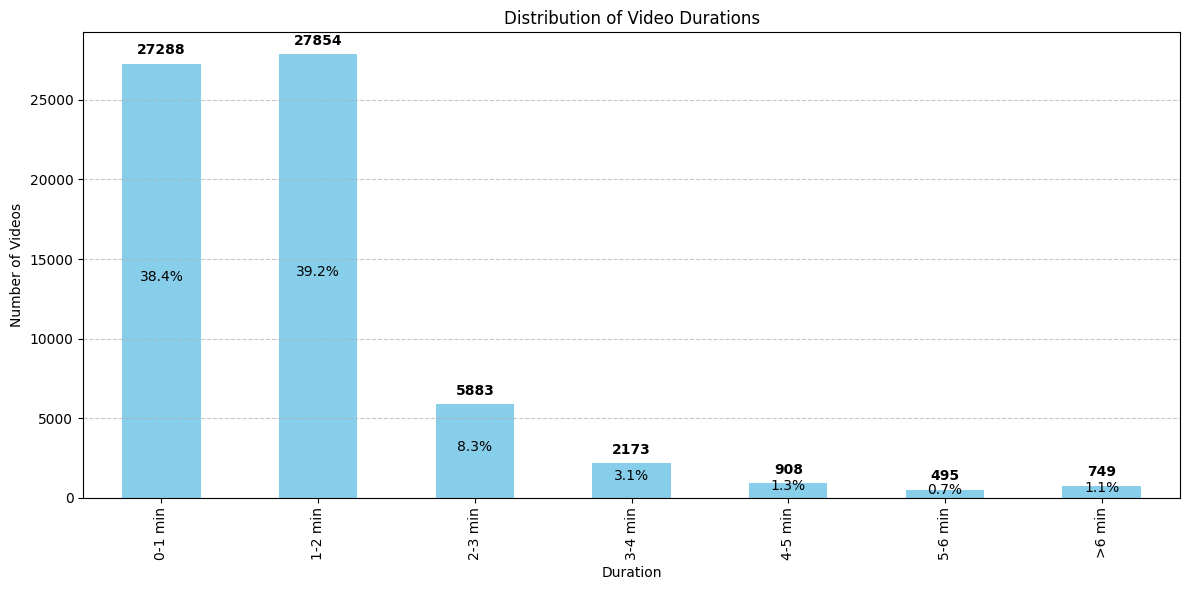


Video Duration Distribution:
                Count  Percentage
video.duration                   
0-1 min         27288   38.435968
1-2 min         27854   39.233196
2-3 min          5883    8.286382
3-4 min          2173    3.060736
4-5 min           908    1.278945
5-6 min           495    0.697222
>6 min            749    1.054989


In [8]:
# Define the bins and labels with more detailed ranges for longer videos
duration_bins = [0, 60, 120, 180, 240, 300, 360, float('inf')]
duration_labels = ['0-1 min', '1-2 min', '2-3 min',
                   '3-4 min', '4-5 min', '5-6 min', '>6 min']

# Calculate the distribution
duration_counts = pd.cut(video_df['video.duration'], bins=duration_bins,
                         labels=duration_labels).value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(12, 6))
bar_plot = duration_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Video Durations')
plt.xlabel('Duration')
plt.ylabel('Number of Videos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(duration_counts):
    plt.text(i, count + 600, f'{count}', ha='center', fontweight='bold')

# Display percentage in each bin
total_videos = len(video_df)
for i, (index, count) in enumerate(duration_counts.items()):
    percentage = 100 * count / total_videos
    plt.text(i, count/2, f'{percentage:.1f}%', ha='center', color='black')

plt.tight_layout()
plt.show()

# Print the tabular data
print("\nVideo Duration Distribution:")
duration_table = pd.DataFrame({
    'Count': duration_counts,
    'Percentage': [100 * count / total_videos for count in duration_counts]
})
print(duration_table)

In [9]:
video_df["weekly_score_rank"].value_counts().sort_index()

weekly_score_rank
1.0       70
2.0       70
3.0       70
4.0       70
5.0       70
          ..
1332.0     1
1333.0     1
1334.0     1
1335.0     1
1336.0     1
Name: count, Length: 1336, dtype: int64

<Axes: xlabel='year,week'>

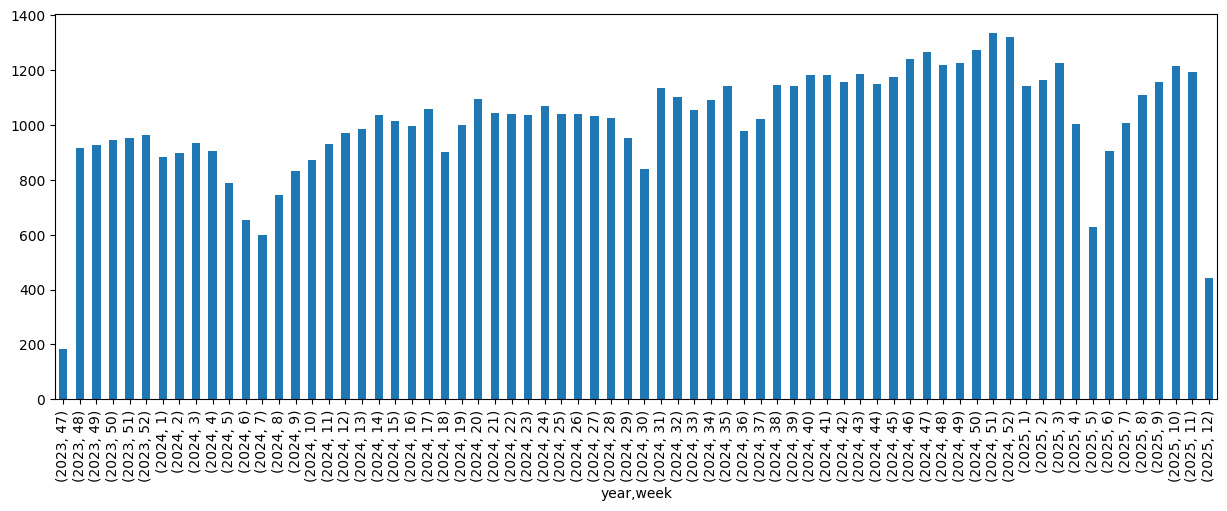

In [10]:
# Calculate the number of videos per week
video_df.groupby(["year", "week"]).size().plot(kind="bar", figsize=(15, 5))

# Lọc top 20 video có xếp hạng cao nhất trong mỗi tuần

In [11]:
# Get top 20 videos by weekly score rank for each year and week
top_weekly_videos = video_df.groupby(['year', 'week']).apply(
    lambda x: x.sort_values('weekly_score_rank').head(20),
    # include_groups=False
).reset_index(drop=True)

# Display the shape of the result
print(
    f"Total groups (year-week combinations): {video_df.groupby(['year', 'week']).ngroups}")
print(f"Total videos in top 20 selection: {len(top_weekly_videos)}")

Total groups (year-week combinations): 70
Total videos in top 20 selection: 1400


/tmp/ipykernel_20054/2266836811.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_weekly_videos = video_df.groupby(['year', 'week']).apply(


In [12]:
top_weekly_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 70 columns):
 #   Column                           Non-Null Count  Dtype                    
---  ------                           --------------  -----                    
 0   Unnamed: 0                       1400 non-null   int64                    
 1   CategoryType                     1400 non-null   float64                  
 2   author.downloadSetting           1400 non-null   float64                  
 3   author.duetSetting               1400 non-null   float64                  
 4   author.id                        1400 non-null   int64                    
 5   author.nickname                  1400 non-null   object                   
 6   author.openFavorite              1400 non-null   bool                     
 7   author.secUid                    1400 non-null   object                   
 8   author.signature                 1384 non-null   object                   
 9   author.s

### Phân tích video.duration

In [13]:
top_weekly_videos["video.duration"].describe()

count    1400.000000
mean      117.934286
std        99.557132
min         0.000000
25%        55.750000
50%        92.500000
75%       151.000000
max       600.000000
Name: video.duration, dtype: float64

<Axes: ylabel='Frequency'>

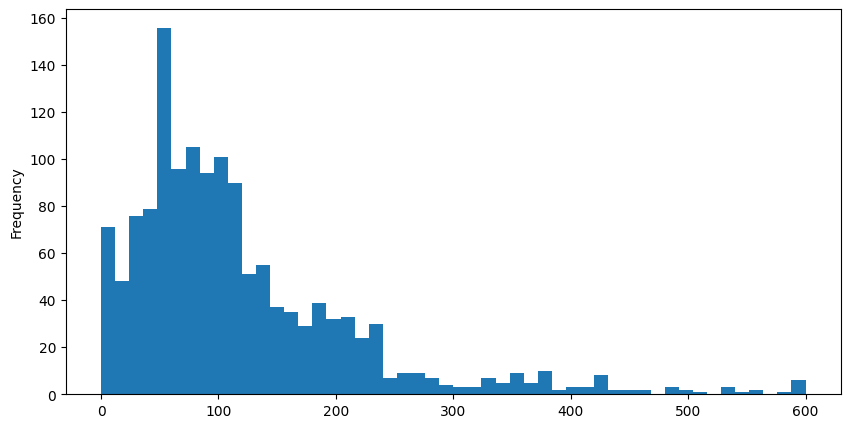

In [14]:
top_weekly_videos["video.duration"].plot(kind="hist", bins=50, figsize=(10, 5))

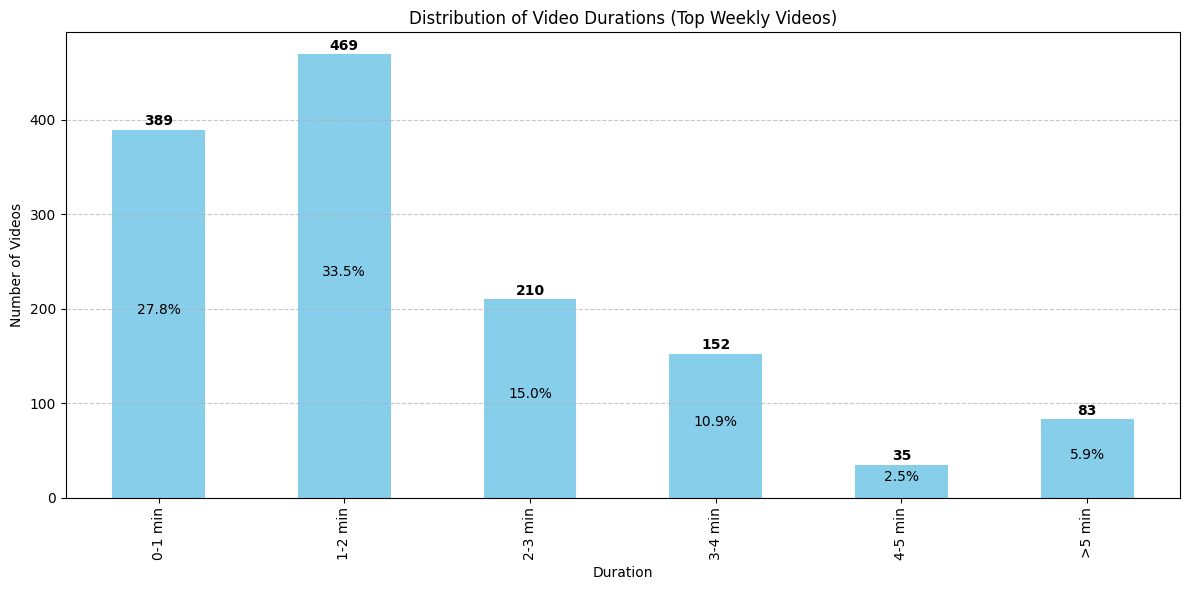


Video Duration Distribution (Top Weekly Videos):
                Count  Percentage
video.duration                   
0-1 min           389   27.785714
1-2 min           469   33.500000
2-3 min           210   15.000000
3-4 min           152   10.857143
4-5 min            35    2.500000
>5 min             83    5.928571


In [15]:
# Define the bins and labels for video duration
duration_bins = [0, 60, 120, 180, 240, 300, float('inf')]
duration_labels = ['0-1 min', '1-2 min', '2-3 min', '3-4 min', '4-5 min', '>5 min']

# Calculate the distribution
duration_counts = pd.cut(top_weekly_videos['video.duration'], bins=duration_bins, labels=duration_labels).value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(12, 6))
bar_plot = duration_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Video Durations (Top Weekly Videos)')
plt.xlabel('Duration')
plt.ylabel('Number of Videos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(duration_counts):
    plt.text(i, count + 5, f'{count}', ha='center', fontweight='bold')

# Display percentage in each bin
total_videos = len(top_weekly_videos)
for i, (index, count) in enumerate(duration_counts.items()):
    percentage = 100 * count / total_videos
    plt.text(i, count/2, f'{percentage:.1f}%', ha='center', color='black')

plt.tight_layout()
plt.show()

# Print the tabular data
print("\nVideo Duration Distribution (Top Weekly Videos):")
duration_table = pd.DataFrame({
    'Count': duration_counts,
    'Percentage': [100 * count / total_videos for count in duration_counts]
})
print(duration_table)

### Tạo cột url từ user_id và video_id

In [16]:
# url = "https://www.tiktok.com/@{author.uniqueId}/video/{video.id}"
top_weekly_videos["video.url"] = top_weekly_videos.apply(
    lambda x: f"https://www.tiktok.com/@{x['author.uniqueId']}/video/{x['video.id']}",
    axis=1
)

In [17]:
for url in top_weekly_videos["video.url"].head(5):
    print(url)

https://www.tiktok.com/@phansanh96/video/7305759157976681735
https://www.tiktok.com/@thanhtatmukbang/video/7305779617548455214
https://www.tiktok.com/@gauvlogs1997/video/7305379124066012418
https://www.tiktok.com/@tungss93/video/7305740277703052545
https://www.tiktok.com/@bethanh117_/video/7305745168232221954


In [18]:
# Filter data for transcripts
transcript_df = top_weekly_videos[
    ["year", "week", "weekly_score", "weekly_score_rank",
     "author.uniqueId", "video.id", "desc", "video.duration",
     "hashtags", "num_hashtags", "engagement_rate", "video.url"]
]

In [19]:
transcript_df.head(21)

,year,week,weekly_score,weekly_score_rank,author.uniqueId,video.id,desc,video.duration,hashtags,num_hashtags,engagement_rate,video.url
0,2023,47,81.341077,1.0,phansanh96,7305759157976681735,Cuối tháng chỉ dám ăn mì tôm cầm hơi #phansanh...,113.0,"phansanh96,ancungtiktok,cuocsongnhatban,fpy",4,0.038557,https://www.tiktok.com/@phansanh96/video/73057...
1,2023,47,52.756015,2.0,thanhtatmukbang,7305779617548455214,Lòng xe điếu cỡ này là loại 1 chưa ạh ? #Thanh...,379.0,"thanhtatmukbang,ancungtiktok,mukbang,monngonmo...",4,0.028294,https://www.tiktok.com/@thanhtatmukbang/video/...
2,2023,47,48.126105,3.0,gauvlogs1997,7305379124066012418,Nửa đêm với hột zịch lộn#xuhuong #xh #gauvlogs...,155.0,"xuhuong,xh,gauvlogs,xhtiktok,ankhuya,andem,muk...",12,0.031021,https://www.tiktok.com/@gauvlogs1997/video/730...
3,2023,47,44.061760,4.0,tungss93,7305740277703052545,Ăn thử xúc xích vòng hun khói. #foodtiktok #fo...,115.0,"foodtiktok,foodreview,ancungtiktok,learnontikt...",6,0.055066,https://www.tiktok.com/@tungss93/video/7305740...
4,2023,47,41.153535,5.0,bethanh117_,7305745168232221954,Theo dòng chảy sự kiệnnn #keosap #vulaci #AnCu...,38.0,"keosap,vulaci,ancungtiktok,tiktokcommunityvn,x...",5,0.036564,https://www.tiktok.com/@bethanh117_/video/7305...
5,2023,47,35.091245,6.0,haan.nghiem,7305725599572708626,"Vừa được ăn thử thách, vừa làm được những điều...",115.0,"behananbunsua,behan,foodchallenge,tolahanne,fo...",8,0.065347,https://www.tiktok.com/@haan.nghiem/video/7305...
6,2023,47,29.507397,7.0,dau.rv,7305366271976082689,Quầy line tráng miệng xịn lắm luôn ý #daurevie...,106.0,"daureview,ancungtiktok,buffetnuong,buffetnuong...",12,0.033218,https://www.tiktok.com/@dau.rv/video/730536627...
7,2023,47,26.247103,8.0,khoasheep,7305601624456563970,Có tiệm bánh croissant nào ngon hơn tiệm này k...,76.0,"khoasheep,reviewanngon,ancungtiktok,croissant",4,0.072108,https://www.tiktok.com/@khoasheep/video/730560...
8,2023,47,24.823077,9.0,phuongoanh.daily,7305410066394418433,Túi không khí nên mua hay không nên #phuongoan...,63.0,"phuongoanhdaily,learnontiktok,ancungtiktok",3,0.031544,https://www.tiktok.com/@phuongoanh.daily/video...
9,2023,47,23.365980,10.0,bachuareview,7305416701447818504,buffet lẩu đài loan mới toe ưu đãi hời quá trờ...,74.0,"ancungtiktok,learnontiktok,bachuareview,vtmgr",4,0.022697,https://www.tiktok.com/@bachuareview/video/730...


In [20]:
transcript_df.to_csv("./data/interim/top_20_weekly_videos.csv", index=False)